# 1. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2



# 2. Define the Generator

In [2]:
# Define the DCGAN Generator
def build_dcgan_generator():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(256 * 16 * 16, input_dim=100))
    model.add(layers.Reshape((16, 16, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh'))
    
    return model

# 3. Define the Discriminator

In [3]:
def build_dcgan_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# 4. Build and Compile the GAN

In [4]:
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss='binary_crossentropy', metrics=['accuracy'])
    
    discriminator.trainable = False  # Discriminator is frozen during GAN training
    
    noise = layers.Input(shape=(100,))
    generated_image = generator(noise)
    validity = discriminator(generated_image)
    
    gan = tf.keras.Model(noise, validity)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                loss='binary_crossentropy')
    
    return gan


# 5. Training Process

In [5]:

def load_real_images(folder, image_size=(64, 64)):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)  # Load image using OpenCV
        if img is not None:  # Ensure the image was loaded correctly
            img = cv2.resize(img, image_size)  # Resize to 64x64
            img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
            img = (img - 0.5) * 2  # Normalize to range [-1, 1] for tanh
            images.append(img)
        else:
            print(f"Warning: Could not load image {img_path}")
    return np.array(images)


real_images = load_real_images(r'Data\Real Data')
stylized = load_real_images(r'Data\Natural pic stylized')
real_images = np.concatenate([real_images,stylized],axis=0)

100%|██████████| 1312/1312 [00:12<00:00, 106.13it/s]


In [6]:
def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
def save_generated_image(epoch, generator):
    noise = np.random.normal(0, 1, (1, 100))
    generated_image = generator.predict(noise)[0]
    generated_image = 0.5 * generated_image + 0.5
    
    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')
    
    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.close()

In [8]:
def train_gan(generator, discriminator, gan, real_images, epochs=100000, batch_size=64, discriminator_steps=2):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator multiple times
        for _ in range(discriminator_steps):
            # Randomly select real images
            idx = np.random.randint(0, real_images.shape[0], half_batch)
            real_batch = real_images[idx]

            # Generate fake images
            noise = np.random.normal(0, 1, (half_batch, 100))
            generated_images = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(real_batch, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise and train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress and save checkpoints
        if epoch % 100 == 0:
            print(f"{epoch}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
            save_generated_image(epoch, generator)
            plot_generated_images(generator, epoch)

        # Save model checkpoints every 5000 epochs
        if epoch % 5000 == 0:
            if not os.path.exists('checkpoints'):
                os.makedirs('checkpoints')
            generator.save(f"checkpoints/generator_epoch_{epoch}.h5")
            discriminator.save(f"checkpoints/discriminator_epoch_{epoch}.h5")
            gan.save(f"checkpoints/gan_epoch_{epoch}.h5")



# 6. Run the Training

1/1 [==============================] - 0s 20ms/step
0/10000, D Loss: 0.6399150192737579, G Loss: 0.48565688729286194
1/1 [==============================] - 0s 212ms/step


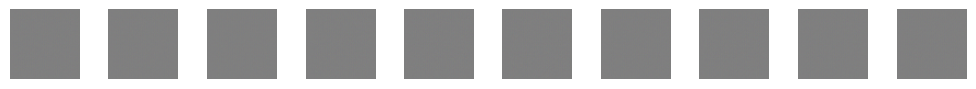

1/1 [==============================] - 0s 17ms/step
100/10000, D Loss: 8.442770013061818e-05, G Loss: 0.0006952155963517725
1/1 [==============================] - 0s 25ms/step


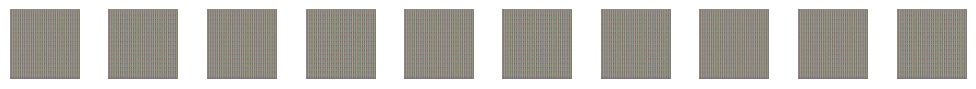

1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: 

In [9]:
generator = build_dcgan_generator()
discriminator = build_dcgan_discriminator()
gan = build_gan(generator, discriminator)

# real_images = load_real_images(r'Data\Real Data')
# stylized = load_real_images(r'Data\Natural pic stylized')
# real_images = np.concatenate([real_images, stylized], axis=0)

train_gan(generator, discriminator, gan, real_images, epochs=10000, batch_size=64)

# 